# Factor Analysis for Sensory Data

This notebook demonstrates **Factor Analysis (FA)**, a dimensionality reduction technique used to identify underlying patterns in sensory data. Factor analysis helps reduce many correlated sensory attributes into fewer meaningful factors that represent the main dimensions of variation.

**What is Factor Analysis?**
- A statistical method that identifies latent (hidden) factors that explain correlations among observed variables
- Reduces dimensionality by finding a smaller number of factors that capture most of the information
- Helps interpret complex sensory data by identifying which attributes group together
- Useful for understanding the underlying structure of sensory attributes

**Learning Objectives:**
- Understand the concept of factor analysis and when to use it
- Perform exploratory factor analysis on sensory data
- Interpret factor loadings and factor scores
- Visualize products and attributes in factor space
- Understand scree plots for determining the number of factors

---

## Installation Instructions

Before running this notebook, make sure you have the required packages installed. Run the following command in your terminal or command prompt:

```bash
pip install pandas numpy factor-analyzer scikit-learn matplotlib seaborn openpyxl
```

**Note:** `openpyxl` is required to read Excel files (`.xls` and `.xlsx` formats), and `factor-analyzer` is a specialized package for factor analysis.

If you are using Anaconda, you can also install using conda:
```bash
conda install pandas numpy scikit-learn matplotlib seaborn openpyxl
pip install factor-analyzer
```

**Note:** The `factor-analyzer` package may not be available in conda, so use pip for that specific package.


## 1. Import Required Libraries

We will import all necessary libraries for data manipulation, factor analysis, and visualization.

In [3]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Factor analysis
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import FactorAnalysis

# Data preprocessing
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Illinois colors for visualizations
illiniorange = "#FF5F05"
illiniblue = "#13294B"

## 2. Load and Explore Data

We will load the sensory data from an Excel file. This dataset contains sensory evaluations of pea products, including multiple attributes measured by trained assessors.


In [4]:
# Load the peas dataset from Excel file
peas = pd.read_excel("data/peaimpba.xls")

# Display basic information about the dataset
print("Dataset shape:", peas.shape)
print("\nColumn names:")
print(peas.columns.tolist())
print("\nFirst few rows:")
print(peas.head())


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Dataset shape: (576, 24)

Column names:
['DATE', 'ORDER', 'PRODUCT', 'PREVIOUS', 'PEA_OD', 'POD_OD', 'SWEET_OD', 'EARTH_OD', 'PEA_TA', 'POD_TA', 'SWEET_TA', 'EARTH_TA', 'CRISP', 'JUICY', 'HARD', 'MEALY', 'SKIN_VIS', 'REPLICAT', 'SIZE', 'COLOUR', 'SUCROSE', 'VARIETY', 'ASSESSOR', 'I']

First few rows:
    DATE  ORDER  PRODUCT  PREVIOUS  PEA_OD  POD_OD  SWEET_OD  EARTH_OD  \
0  12451      3      132       701     8.5     3.0       2.7       1.9   
1  12451      1      132         0     4.7     7.8       2.5       1.6   
2  12451      2      132       701     7.1     6.2       4.0       2.6   
3  12451      3      132       494     6.7     3.4       9.4       1.3   
4  12451      1      132         0     8.3     3.8       9.3       1.9   

   PEA_TA  POD_TA  ...  HARD  MEALY  SKIN_VIS  REPLICAT  SIZE  COLOUR  \
0     9.0     4.3  ...   5.4    8.5       7.9         1     4       2   
1     3.6     5.3  ...   7.0    5.

## 3. Prepare Data for Factor Analysis

Before performing factor analysis, we need to:
1. Identify which columns contain sensory attributes (not design variables)
2. Aggregate data to product means (averaging across assessors and replicates)
3. Standardize the attributes so they are on the same scale

**Why aggregate to product means?**
- Factor analysis works best with one observation per product
- Averaging across assessors and replicates reduces noise and focuses on product differences
- This creates a product × attributes matrix suitable for factor analysis


In [5]:
# Define design columns (identifiers, not sensory attributes)
id_cols = ["PRODUCT", "ASSESSOR", "REPLICAT"]

# Define sensory attributes to include in factor analysis
# These are the variables we want to analyze
attr_cols = [
    "PEA_OD", "POD_OD", "SWEET_OD", "EARTH_OD",  # Odor attributes
    "PEA_TA", "POD_TA", "SWEET_TA", "EARTH_TA",  # Taste attributes
    "CRISP", "JUICY", "HARD", "MEALY", "SKIN_VIS"  # Texture attributes
]

# Aggregate to product means
# This averages across all assessors and replicates for each product
pea_means = peas.groupby("PRODUCT")[attr_cols].mean().reset_index()

print(f"Number of products: {len(pea_means)}")
print(f"Number of attributes: {len(attr_cols)}")
print("\nProduct means (first few rows):")
print(pea_means.head())


Number of products: 16
Number of attributes: 13

Product means (first few rows):
   PRODUCT    PEA_OD    POD_OD  SWEET_OD  EARTH_OD    PEA_TA    POD_TA  \
0      132  6.190631  4.761280  5.702679  3.322767  6.462596  5.299030   
1      231  6.835831  4.596058  6.559922  1.233880  7.415731  6.999687   
2      237  5.847773  3.646995  5.549107  2.844195  5.869739  4.127601   
3      315  7.105420  6.490236  6.682216  2.079926  7.820051  6.184728   
4      494  6.074281  3.272026  5.822303  2.133703  8.247295  4.616130   

   SWEET_TA  EARTH_TA     CRISP     JUICY      HARD      MEALY  SKIN_VIS  
0  6.297249  1.833867  5.987158  4.777788  7.545945   8.816918  8.787015  
1  6.977556  0.844975  8.417191  9.321788  4.048575   1.706168  3.997036  
2  6.454392  2.251683  3.962158  3.920645  6.263802  11.377632  9.826300  
3  8.145476  1.242062  7.832071  7.399544  5.012152   3.764850  4.937617  
4  8.991116  1.071740  8.899489  8.777334  4.333170   3.234926  4.058861  


## 4. Standardize the Data

Standardization is important for factor analysis because:
- Attributes may have different scales (e.g., odor intensity vs. texture hardness)
- Factor analysis is based on correlations, which are scale-dependent
- Standardizing ensures all attributes contribute equally to the analysis

**Standardization formula:** z = (x - mean) / standard deviation


In [6]:
# Extract the attribute matrix (products × attributes)
X = pea_means[attr_cols].values

# Standardize the attributes
# This centers each attribute at 0 and scales to unit variance
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

print(f"Data matrix shape: {Xz.shape} (products × attributes)")
print(f"Mean of standardized data (should be ~0): {Xz.mean():.6f}")
print(f"Std of standardized data (should be ~1): {Xz.std():.6f}")


Data matrix shape: (16, 13) (products × attributes)
Mean of standardized data (should be ~0): -0.000000
Std of standardized data (should be ~1): 1.000000


## 5. Determine the Number of Factors

Before performing factor analysis, we need to decide how many factors to extract. The **scree plot** helps with this decision by showing the eigenvalues of the correlation matrix.

**How to interpret a scree plot:**
- Each eigenvalue represents the variance explained by a factor
- Look for an "elbow" in the plot where eigenvalues drop sharply
- Factors with eigenvalues > 1 are often considered meaningful (Kaiser criterion)
- The goal is to retain enough factors to explain most variance while keeping the model simple


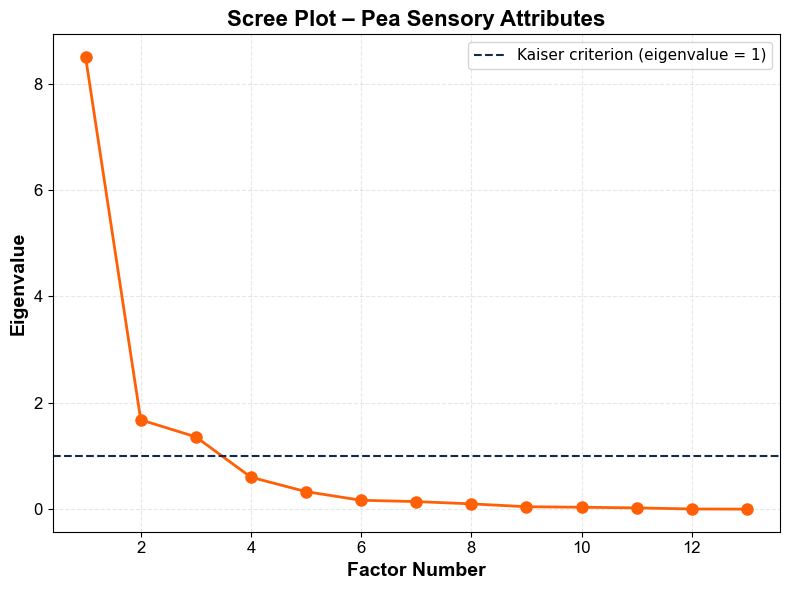

Eigenvalues (sorted):
Factor 1: 8.500
Factor 2: 1.680
Factor 3: 1.360
Factor 4: 0.602
Factor 5: 0.330
Factor 6: 0.168
Factor 7: 0.143
Factor 8: 0.101
Factor 9: 0.047
Factor 10: 0.037
Factor 11: 0.025
Factor 12: 0.004
Factor 13: 0.002

Selected number of factors: 3


In [7]:
# Calculate correlation matrix
corr = np.corrcoef(Xz, rowvar=False)

# Calculate eigenvalues and eigenvectors
# Eigenvalues indicate how much variance each factor explains
eigvals, eigvecs = np.linalg.eig(corr)

# Sort eigenvalues in descending order
eigvals_sorted = sorted(eigvals, reverse=True)

# Create scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigvals_sorted) + 1),
         eigvals_sorted, 
         marker="o", 
         markersize=8,
         color=illiniorange,
         linewidth=2)
plt.axhline(1.0, color=illiniblue, linestyle="--", linewidth=1.5, 
            label="Kaiser criterion (eigenvalue = 1)")
plt.xlabel("Factor Number", fontsize=14, fontweight="bold", fontfamily="Arial")
plt.ylabel("Eigenvalue", fontsize=14, fontweight="bold", fontfamily="Arial")
plt.title("Scree Plot – Pea Sensory Attributes", 
          fontsize=16, fontweight="bold", fontfamily="Arial")
plt.xticks(fontsize=12, fontfamily="Arial")
plt.yticks(fontsize=12, fontfamily="Arial")
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Display eigenvalues
print("Eigenvalues (sorted):")
for i, val in enumerate(eigvals_sorted, 1):
    print(f"Factor {i}: {val:.3f}")

# Choose number of factors based on scree plot
# Typically, we look for factors with eigenvalue > 1 or the "elbow" in the plot
n_factors = 3
print(f"\nSelected number of factors: {n_factors}")


## 6. Perform Factor Analysis

Now we will fit the factor analysis model. Factor analysis identifies underlying factors that explain the correlations among sensory attributes.

**What are factor loadings?**
- Loadings show how strongly each attribute is associated with each factor
- High absolute loadings (close to ±1) indicate strong association
- Loadings can be positive or negative, indicating direction of relationship

**What are factor scores?**
- Factor scores represent where each product lies in the factor space
- Products with similar scores on a factor have similar attribute profiles
- Useful for visualizing product relationships


In [9]:

# Fit factor analysis model
fa = FactorAnalysis(n_components=n_factors)
fa.fit(Xz)

# Extract factor loadings
# Note: sklearn's FactorAnalysis stores components as rows, so we transpose
# Loadings show the correlation between attributes and factors
loadings = pd.DataFrame(
    fa.components_.T,
    index=attr_cols,
    columns=[f"F{i+1}" for i in range(n_factors)]
)

print("Factor Loadings:")
print("="*60)
print("Loadings show how strongly each attribute relates to each factor")
print("Values range from -1 to +1, with higher absolute values = stronger relationship")
print("\n" + loadings.round(3).to_string())

# Calculate factor scores for products
# Factor scores indicate where each product is positioned in factor space
factor_scores = fa.transform(Xz)
scores_df = pd.DataFrame(
    factor_scores,
    columns=[f"F{i+1}" for i in range(n_factors)]
)
scores_df["PRODUCT"] = pea_means["PRODUCT"]

print("\n" + "="*60)
print("Factor Scores (first few products):")
print("Factor scores show the position of each product in factor space")
print(scores_df.head().to_string(index=False))



Factor Loadings:
Loadings show how strongly each attribute relates to each factor
Values range from -1 to +1, with higher absolute values = stronger relationship

             F1     F2     F3
PEA_OD   -0.746  0.324 -0.462
POD_OD   -0.102 -0.075 -0.538
SWEET_OD -0.805  0.307 -0.231
EARTH_OD  0.836 -0.165  0.479
PEA_TA   -0.938  0.266  0.166
POD_TA   -0.441 -0.346 -0.377
SWEET_TA -0.873  0.374  0.260
EARTH_TA  0.872 -0.273  0.292
CRISP    -0.740 -0.370  0.175
JUICY    -0.964 -0.211 -0.053
HARD      0.771  0.232  0.310
MEALY     0.920  0.349 -0.104
SKIN_VIS  0.882  0.404 -0.005

Factor Scores (first few products):
Factor scores show the position of each product in factor space
       F1        F2        F3  PRODUCT
 0.883792  0.514936  0.297824      132
-0.907787 -1.692010 -1.100387      231
 1.293783  1.267364 -0.225225      237
-0.591887 -0.213697  0.027678      315
-0.898355 -0.523585  1.270596      494


## 7. Visualize Products in Factor Space

A scatter plot of factor scores shows how products relate to each other. Products that are close together in factor space have similar sensory profiles. This visualization helps identify:
- Product clusters (similar products)
- Outliers (unique products)
- The main dimensions of product variation


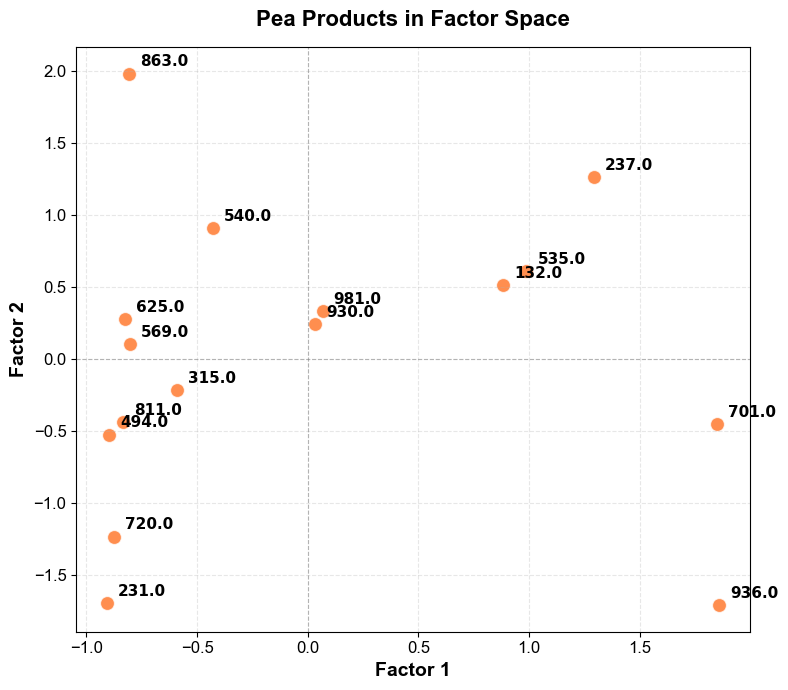

In [10]:
# Create scatter plot of products in factor space
plt.figure(figsize=(8, 7))
sns.scatterplot(x="F1", y="F2", data=scores_df, s=100, color=illiniorange, alpha=0.7)

# Add product labels
for _, row in scores_df.iterrows():
    plt.text(row["F1"] + 0.05, row["F2"] + 0.05, 
             str(row["PRODUCT"]), 
             fontsize=11, 
             fontweight='bold',
             ha='left')

# Add reference lines at zero
plt.axhline(0, color="grey", linewidth=0.8, linestyle='--', alpha=0.5)
plt.axvline(0, color="grey", linewidth=0.8, linestyle='--', alpha=0.5)

plt.title("Pea Products in Factor Space", 
          fontsize=16, fontweight="bold", fontfamily="Arial", pad=15)
plt.xlabel("Factor 1", fontsize=14, fontweight="bold", fontfamily="Arial")
plt.ylabel("Factor 2", fontsize=14, fontweight="bold", fontfamily="Arial")
plt.xticks(fontsize=12, fontfamily="Arial")
plt.yticks(fontsize=12, fontfamily="Arial")
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## 8. Visualize Factor Loadings

A heatmap of factor loadings helps interpret what each factor represents. By examining which attributes have high loadings on each factor, we will understand the underlying dimensions of the sensory space.

**Interpreting the heatmap:**
- Red colors indicate positive loadings (attributes increase together)
- Blue colors indicate negative loadings (attributes vary in opposite directions)
- Darker colors indicate stronger relationships
- Attributes with high loadings on the same factor tend to co-occur


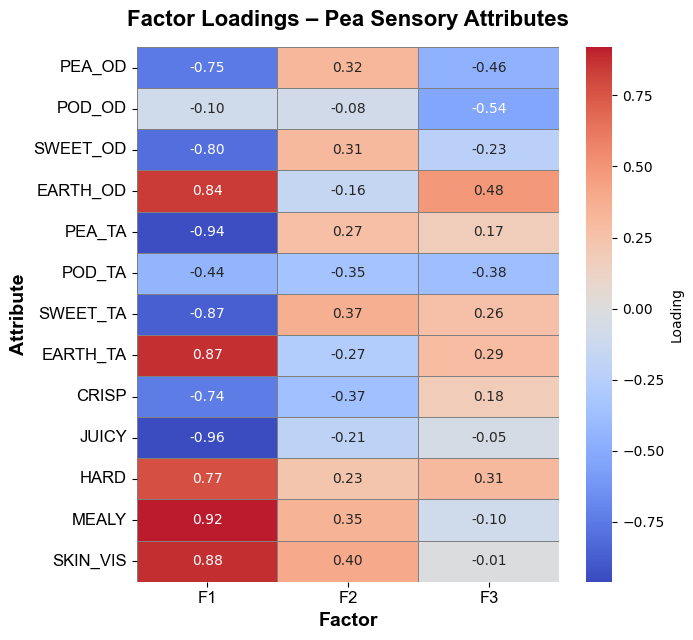


Interpretation Guide:
High positive loadings (>0.5): Attribute strongly associated with factor
High negative loadings (<-0.5): Attribute inversely associated with factor
Low loadings (near 0): Attribute not well explained by this factor


In [11]:
# Create heatmap of factor loadings
plt.figure(figsize=(7, len(attr_cols) * 0.5))
sns.heatmap(loadings.round(2),
            annot=True, 
            cmap="coolwarm", 
            center=0,
            fmt='.2f',
            cbar_kws={"label": "Loading"},
            linewidths=0.5,
            linecolor='gray')

plt.title("Factor Loadings – Pea Sensory Attributes", 
          fontsize=16, fontweight="bold", fontfamily="Arial", pad=15)
plt.xlabel("Factor", fontsize=14, fontweight="bold", fontfamily="Arial")
plt.ylabel("Attribute", fontsize=14, fontweight="bold", fontfamily="Arial")
plt.xticks(fontsize=12, fontfamily="Arial")
plt.yticks(fontsize=12, fontfamily="Arial")
plt.tight_layout()
plt.show()

# Summary interpretation
print("\nInterpretation Guide:")
print("="*60)
print("High positive loadings (>0.5): Attribute strongly associated with factor")
print("High negative loadings (<-0.5): Attribute inversely associated with factor")
print("Low loadings (near 0): Attribute not well explained by this factor")
